<a href="https://colab.research.google.com/github/mamonalsalihy/Emotion_Detection/blob/main/Models/CNN_github_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tqdm.auto import tqdm
import os
import pandas as pd
import csv
import pickle as pkl
import nltk
import matplotlib.pyplot as plt
import seaborn as sea
import re
import os
import spacy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

import math
from itertools import chain

import gensim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Must upload the dataset splits to google session to read the data.
test_path = './test.csv'
train_path = './train.csv'
valid_path = './valid.csv'

In [ ]:
with open(train_path, "r") as intrain: 
    train = pd.read_csv(intrain)
with open(valid_path, "r") as indev: 
    valid = pd.read_csv(indev)
with open(test_path, "r") as intest: 
    test = pd.read_csv(intest)

In [ ]:
train

,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags,clean_prompt,clean_utterance,speaker_label,emotion_category,Total Function Words,Total Pronouns,Personal Pronouns,First Person Singular,First Person Plural,Second Person,Third Person Singular,Third Person Plural,Impersonal Pronouns,Articles,Common Verbs,Auxiliary Verbs,Past Tense,Present Tense,Future Tense,Adverbs,Prepositions,Conjunctions,Negations,Quantifiers,Number,Swear Words,Social Processes,Family,Friends,Humans,Affective Processes,Positive Emotion,...,Perceptual Processes,See,Hear,Feel,Biological Processes,Body,Health,Sexual,Ingestion,Relativity,Motion,Space,Time,Work,Achievement,Leisure,Home,Money,Religion,Death,Assent,Nonfluencies,Fillers,Total first person,Total third person,Positive feelings,Optimism and energy,Communication,Other references to people,Up,Down,Occupation,School,Sports,TV,Music,Metaphysical issues,Physical states and functions,Sleeping,Grooming
0,hit:0_conv:1,1,sentimental,I remember going to the fireworks with my best...,1,I remember going to see the fireworks with my ...,5|5|5_2|2|5,NaN,i remember going to the fireworks with my best...,i remember going to see the fireworks with my ...,speaker,1,68.000000,16.000000,12.000000,8.000000,4.0,0.0,0.000000,0.0,4.000000,12.000000,8.000000,4.000000,8.000000,0.0,0.0,8.0,16.000000,4.0,0.0,8.000000,0.0,0.0,12.000000,0.000000,4.0,4.0,8.0,8.0,...,4.0,0.0,0.0,4.0,0.000000,0.0,0.000000,0.000000,0.0,12.000000,4.0,8.000000,4.000000,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,hit:0_conv:1,2,sentimental,I remember going to the fireworks with my best...,0,Was this a friend you were in love with_comma_...,5|5|5_2|2|5,NaN,i remember going to the fireworks with my best...,was this a friend you were in love with or jus...,listener,1,68.000000,16.000000,12.000000,8.000000,4.0,0.0,0.000000,0.0,4.000000,12.000000,8.000000,4.000000,8.000000,0.0,0.0,8.0,16.000000,4.0,0.0,8.000000,0.0,0.0,12.000000,0.000000,4.0,4.0,8.0,8.0,...,4.0,0.0,0.0,4.0,0.000000,0.0,0.000000,0.000000,0.0,12.000000,4.0,8.000000,4.000000,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,hit:0_conv:1,3,sentimental,I remember going to the fireworks with my best...,1,This was a best friend. I miss her.,5|5|5_2|2|5,NaN,i remember going to the fireworks with my best...,this was a best friend. i miss her.,speaker,1,68.000000,16.000000,12.000000,8.000000,4.0,0.0,0.000000,0.0,4.000000,12.000000,8.000000,4.000000,8.000000,0.0,0.0,8.0,16.000000,4.0,0.0,8.000000,0.0,0.0,12.000000,0.000000,4.0,4.0,8.0,8.0,...,4.0,0.0,0.0,4.0,0.000000,0.0,0.000000,0.000000,0.0,12.000000,4.0,8.000000,4.000000,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,hit:0_conv:1,4,sentimental,I remember going to the fireworks with my best...,0,Where has she gone?,5|5|5_2|2|5,NaN,i remember going to the fireworks with my best...,where has she gone?,listener,1,68.000000,16.000000,12.000000,8.000000,4.0,0.0,0.000000,0.0,4.000000,12.000000,8.000000,4.000000,8.000000,0.0,0.0,8.0,16.000000,4.0,0.0,8.000000,0.0,0.0,12.000000,0.000000,4.0,4.0,8.0,8.0,...,4.0,0.0,0.0,4.0,0.000000,0.0,0.000000,0.000000,0.0,12.000000,4.0,8.000000,4.000000,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,hit:0_conv:1,5,sentimental,I remember going to the fireworks with my best...,1,We no longer talk.,5|5|5_2|2|5,NaN,i remember going to the fireworks with my best...,we no longer talk.,speaker,1,68.000000,16.000000,12.000000,8.000000,4.0,0.0,0.000000,0.0,4.000000,12.000000,8.000000,4.000000,8.000000,0.0,0.0,8.0,16.000000,4.0,0.0,8.000000,0.0,0.0,12.000000,0.000000,4.0,4.0,8.0,8.0,...,4.0,0.0,0.0,4.0,0.000000,0.0,0.000000,0.000000,0.0,12.000000,4.0,8.000000,4.000000,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

##Feature Builder Class

In [ ]:
class Sequencer(object):
    def __init__(self, tokens, bos_token='<s>', eos_token='</s>', unk_token='<unk>', pad_token='<pad>'):
        self.word2idx = {}
        self.idx2word = {}

        self.pad_index = self.add_token(pad_token)
        self.unk_index = self.add_token(unk_token) 
        self.bos_index = self.add_token(bos_token)
        self.eos_index = self.add_token(eos_token)

        for token in tokens:
            self.add_token(token)

    def add_token(self, token):

        self.word2idx[token] = new_index = len(self.word2idx)
        self.idx2word[new_index] = token

        return new_index

    def encode(self, tokens):
        # Input will look like:
        # [<s>, w1, w2, ..., wn, </s>]

        sequence = [self.bos_index]
        for token in tokens:

            index = self.word2idx.get(token, self.unk_index)
            sequence.append(index)
        sequence.append(self.eos_index)

        return sequence

    def create_padded_tensor(self, sequences):
        # Input: [[4, 2, 3], [5, 4, 2, 4, 6]]
        # Output:
        # Tensor
        # 4 2 3 0 0
        # 5 4 2 4 6

        # Given a list of sequences, pad all to the same length
        lengths = [len(sequence) for sequence in sequences]
        max_seq_len = max(lengths)
        tensor = torch.full((len(sequences), max_seq_len), self.pad_index, dtype=torch.long)

        for i, sequence in enumerate(sequences):
            for j, token in enumerate(sequence):
                tensor[i][j] = token
        return tensor

# For converting labels into indices
class LabelIndexer(object):
    def __init__(self, labels):
        self.label2idx = {label: i for i, label in enumerate(labels)}
        self.idx2label = {i:label for label, i in self.label2idx.items()}
        self.labels = labels

    def encode(self, y):
        return self.label2idx[y]

    def encode_batch(self, ys):
        return torch.LongTensor([self.encode(y) for y in ys])


## Dataset class

In [ ]:
class EmpatheticDataset(Dataset):
    def __init__(self, texts, liwc, labels, input_transformer, output_transformer):
        self.texts = texts
        self.labels = labels
        self.liwc  = liwc.values
        self.input_transformer = input_transformer
        self.output_transformer = output_transformer

    def __getitem__(self, index): # Return a single example
        text = self.texts[index]
        label = self.labels[index]
        liwc = self.liwc[index]
        x_liwc = torch.tensor(liwc)
        x = self.input_transformer(text)
        y = self.output_transformer(label)       
        return x, y

    def __len__(self):
        return len(self.texts)

In [ ]:
class EmpatheticDatasetLIWC(Dataset):
    def __init__(self, texts, liwc, labels, input_transformer, output_transformer):
        self.texts = texts
        self.labels = labels
        self.liwc  = liwc.values
        self.input_transformer = input_transformer
        self.output_transformer = output_transformer

    def __getitem__(self, index): # Return a single example
        text = self.texts[index]
        label = self.labels[index]
        liwc = self.liwc[index]
        x_liwc = torch.tensor(liwc)
        x = self.input_transformer(text)
        y = self.output_transformer(label)       
        return x_liwc.float(), y

    def __len__(self):
        return len(self.texts)

## Trainer Class

In [ ]:
class MultiClassTrainer(object):
    """
    Trainer for training a multi-class classification model
    """

    def __init__(self, model, optimizer, loss_fn, device="cpu", log_every_n=None):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.device = device
        self.loss_fn = loss_fn
        
        self.log_every_n = log_every_n if log_every_n else 0


    def _print_summary(self):
        print(self.model)
        print(self.optimizer)
        print(self.loss_fn)

    def train(self, loader):
        """
        Run a single epoch of training
        """

        self.model.train() # Run model in training mode

        loss_history = []
        running_loss = 0.
        running_loss_history = []

        for i, batch in tqdm(enumerate(loader)):
            batch_size = batch[0].shape[0]
            self.optimizer.zero_grad() # Always set gradient to 0 before computing it

            logits = self.model(batch[0].to(self.device)) # Forward pass, # Wx + b
            #print(logits)
            #print(batch[1].view(-1).to(self.device))
            loss = self.loss_fn(logits, batch[1].view(-1).to(self.device)) # Compute loss: Cross entropy loss

            loss_history.append(loss.item())

            

            running_loss += (loss_history[-1] - running_loss) / (i + 1) # Compute rolling average

            if self.log_every_n and i % self.log_every_n == 0:
                print("Running loss: ", running_loss)

            running_loss_history.append(running_loss)

            loss.backward() # Perform backprop, which will compute dL/dw

            nn.utils.clip_grad_norm_(self.model.parameters(), 3.0)
            self.optimizer.step() # Update step: w = w - eta * dL / dW

        print("Epoch completed!")
        print("Epoch Loss: ", running_loss)
        print("Epoch Perplexity: ", math.exp(running_loss))

        # The history information can allow us to draw a loss plot
        return loss_history, running_loss_history

    def evaluate(self, loader, labels):
        """
        Evaluate the model on a validation set
        """

        self.model.eval() # Run model in eval mode (disables dropout layer)

        batch_wise_true_labels = []
        batch_wise_predictions = []

        loss_history = []
        running_loss = 0.
        running_loss_history = []

        with torch.no_grad(): # Disable gradient computation - required only during training
            for i, batch in tqdm(enumerate(loader)):
                # batch[0] shape: (batch_size, input_size)

                logits = self.model(batch[0].to(self.device)) # Run forward pass (except we don't store gradients)
                # logits shape: (batch_size, num_classes)
                
                loss = self.loss_fn(logits, batch[1].view(-1).to(self.device)) # Compute loss
                # No backprop is done during validation
                loss_history.append(loss.item())

                running_loss += (loss_history[-1] - running_loss) / (i + 1) # Compute rolling average
                
                running_loss_history.append(running_loss)

                # Converts the raw outputs into probabilities for each class using softmax
                probs = F.softmax(logits, dim=-1) 
                # probs shape: (batch_size, num_classes)

                predictions = torch.argmax(probs, dim=-1) # Output predictions
                # predictions shape: (batch_size)

                batch_wise_true_labels.append(batch[1].tolist())
                batch_wise_predictions.append(predictions.tolist())
        
        # flatten the list of predictions using itertools
        all_true_labels = list(chain.from_iterable(batch_wise_true_labels))
        all_predictions = list(chain.from_iterable(batch_wise_predictions))

        # Now we can generate a classification report
        print("Classification report after epoch:")
        print(classification_report(all_true_labels, all_predictions))
        print(confusion_matrix(all_true_labels,all_predictions))
        return loss_history, running_loss_history

    def get_model_dict(self):
        return self.model.state_dict()

    def run_training(self, train_loader, valid_loader, labels, n_epochs=10):
        # Useful for us to review what experiment we're running
        # Normally, you'd want to save this to a file
        self._print_summary()

        train_losses = []
        train_running_losses = []

        valid_losses = []
        valid_running_losses = []

        for i in range(n_epochs):
            loss_history, running_loss_history = self.train(train_loader)
            valid_loss_history, valid_running_loss_history = self.evaluate(valid_loader, labels)

            train_losses.append(loss_history)
            train_running_losses.append(running_loss_history)

            valid_losses.append(valid_loss_history)
            valid_running_losses.append(valid_running_loss_history)

        # Training done, let's look at the loss curves
        all_train_losses = list(chain.from_iterable(train_losses))
        all_train_running_losses = list(chain.from_iterable(train_running_losses))

        all_valid_losses = list(chain.from_iterable(valid_losses))
        all_valid_running_losses = list(chain.from_iterable(valid_running_losses))

        train_epoch_idx = range(len(all_train_losses))
        valid_epoch_idx = range(len(all_valid_losses))
        # sns.lineplot(epoch_idx, all_losses)
        sns.lineplot(x=train_epoch_idx, y=all_train_running_losses)
        sns.lineplot(x=valid_epoch_idx, y=all_valid_running_losses)
        plt.show()

## Data Preparation

In [ ]:
def convert_column(dataset, column): 
   texts = [text for text in dataset[column]]
   texts = (*texts,)
   return texts


In [ ]:
listener_train = train.loc[train["speaker_label"] == "listener"]
speaker_train = train.loc[train["speaker_label"] == "speaker"]

listener_valid = valid.loc[valid["speaker_label"] == "listener"]
speaker_valid = valid.loc[valid["speaker_label"] == "speaker"]

listener_test = test.loc[train["speaker_label"] == "listener"]
speaker_test = test.loc[train["speaker_label"] == "speaker"]

In [ ]:
train_liwc = train[['Total Function Words', 'Total Pronouns', 'Personal Pronouns', 'First Person Singular', 'First Person Plural', 'Second Person', 'Third Person Singular', 'Third Person Plural', ' Impersonal Pronouns', 'Articles', 'Common Verbs', 'Auxiliary Verbs', 'Past Tense', 'Present Tense', 'Future Tense', 'Adverbs', 'Prepositions', 'Conjunctions', 'Negations', 'Quantifiers', 'Number', 'Swear Words', 'Social Processes', 'Family', 'Friends', 'Humans', 'Affective Processes', 'Positive Emotion', 'Negative Emotion', 'Anxiety', 'Anger', 'Sadness', 'Cognitive Processes', 'Insight', 'Causation', 'Discrepancy', 'Tentative', 'Certainty', 'Inhibition', 'Inclusive', 'Exclusive', 'Perceptual Processes', 'See', 'Hear', 'Feel', 'Biological Processes', 'Body', 'Health', 'Sexual', 'Ingestion', 'Relativity', 'Motion', 'Space', 'Time', 'Work', 'Achievement', 'Leisure', 'Home', 'Money', 'Religion', 'Death', 'Assent', 'Nonfluencies', 'Fillers', 'Total first person', 'Total third person', 'Positive feelings', 'Optimism and energy', 'Communication', 'Other references to people', 'Up', 'Down', 'Occupation', 'School', 'Sports', 'TV', 'Music', 'Metaphysical issues', 'Physical states and functions', 'Sleeping', 'Grooming']]
valid_liwc = valid[['Total Function Words', 'Total Pronouns', 'Personal Pronouns', 'First Person Singular', 'First Person Plural', 'Second Person', 'Third Person Singular', 'Third Person Plural', ' Impersonal Pronouns', 'Articles', 'Common Verbs', 'Auxiliary Verbs', 'Past Tense', 'Present Tense', 'Future Tense', 'Adverbs', 'Prepositions', 'Conjunctions', 'Negations', 'Quantifiers', 'Number', 'Swear Words', 'Social Processes', 'Family', 'Friends', 'Humans', 'Affective Processes', 'Positive Emotion', 'Negative Emotion', 'Anxiety', 'Anger', 'Sadness', 'Cognitive Processes', 'Insight', 'Causation', 'Discrepancy', 'Tentative', 'Certainty', 'Inhibition', 'Inclusive', 'Exclusive', 'Perceptual Processes', 'See', 'Hear', 'Feel', 'Biological Processes', 'Body', 'Health', 'Sexual', 'Ingestion', 'Relativity', 'Motion', 'Space', 'Time', 'Work', 'Achievement', 'Leisure', 'Home', 'Money', 'Religion', 'Death', 'Assent', 'Nonfluencies', 'Fillers', 'Total first person', 'Total third person', 'Positive feelings', 'Optimism and energy', 'Communication', 'Other references to people', 'Up', 'Down', 'Occupation', 'School', 'Sports', 'TV', 'Music', 'Metaphysical issues', 'Physical states and functions', 'Sleeping', 'Grooming']]
test_liwc = test[['Total Function Words', 'Total Pronouns', 'Personal Pronouns', 'First Person Singular', 'First Person Plural', 'Second Person', 'Third Person Singular', 'Third Person Plural', ' Impersonal Pronouns', 'Articles', 'Common Verbs', 'Auxiliary Verbs', 'Past Tense', 'Present Tense', 'Future Tense', 'Adverbs', 'Prepositions', 'Conjunctions', 'Negations', 'Quantifiers', 'Number', 'Swear Words', 'Social Processes', 'Family', 'Friends', 'Humans', 'Affective Processes', 'Positive Emotion', 'Negative Emotion', 'Anxiety', 'Anger', 'Sadness', 'Cognitive Processes', 'Insight', 'Causation', 'Discrepancy', 'Tentative', 'Certainty', 'Inhibition', 'Inclusive', 'Exclusive', 'Perceptual Processes', 'See', 'Hear', 'Feel', 'Biological Processes', 'Body', 'Health', 'Sexual', 'Ingestion', 'Relativity', 'Motion', 'Space', 'Time', 'Work', 'Achievement', 'Leisure', 'Home', 'Money', 'Religion', 'Death', 'Assent', 'Nonfluencies', 'Fillers', 'Total first person', 'Total third person', 'Positive feelings', 'Optimism and energy', 'Communication', 'Other references to people', 'Up', 'Down', 'Occupation', 'School', 'Sports', 'TV', 'Music', 'Metaphysical issues', 'Physical states and functions', 'Sleeping', 'Grooming']]


# prompts
train_prompt = convert_column(train,'clean_prompt')
valid_prompt = convert_column(valid,'clean_prompt')
test_prompt = convert_column(test,'clean_prompt')

# utterances
train_utterance = convert_column(train,'clean_utterance')
valid_utterance = convert_column(valid,'clean_utterance')
test_utterance = convert_column(test,'clean_utterance')

# 32 emotions
train_context_labels = convert_column(train,'context')
valid_context_labels = convert_column(valid,'context')
test_context_labels = convert_column(test,'context')

# 3 emotions
train_grouped_labels = convert_column(train,'emotion_category')
valid_grouped_labels = convert_column(valid, "emotion_category")
test_grouped_labels = convert_column(test, "emotion_category")

##CNN

In [ ]:
#Only run when testing on PROMPTS
# Removing duplicates
train = train.drop_duplicates(subset=['clean_prompt'])
valid = valid.drop_duplicates(subset=['clean_prompt'])
#test = test.drop_duplicates(subset=['clean_prompt'])

In [ ]:
def flatten_list(labels):
  return list(set([tag for tag_seq in labels for tag in tag_seq.split()]))

In [ ]:
train_prompt_flattened = flatten_list(train_prompt)

# Prompts Dataloader w/ 32 labels

In [ ]:
label_indexer = LabelIndexer(list(set(train_context_labels+valid_context_labels)))
output_transformer = lambda label: torch.LongTensor([label_indexer.encode(label)])

# embeddings
sequencer_ = Sequencer(train_prompt_flattened)
sequence_input_transformer_ = lambda text: sequencer_.encode(text)

sequence_input_transformer = lambda text: sequencer.encode(text)

def prepare_batch(batch, sequencer):
    # batch: [batch_len, (text, label)]
    texts, labels = zip(*batch)
    text_tensor = sequencer.create_padded_tensor(texts)
    return (text_tensor, torch.stack(labels))


# wrapper class without liwc features
#train_sequence_dataset = EmpatheticDataset(train_utterance, train_grouped_labels, sequence_input_transformer_, output_transformer)
#valid_sequence_dataset = EmpatheticDataset(valid_utterance, valid_grouped_labels, sequence_input_transformer_, output_transformer)
#test_sequence_dataset = EmpatheticDataset(test_utterance,test_grouped_labels,sequence_input_transformer_,output_transformer)

# wrapper class with liwc features
train_sequence_dataset = EmpatheticDataset(train_prompt, train_liwc, train_context_labels, sequence_input_transformer_, output_transformer)
valid_sequence_dataset = EmpatheticDataset(valid_prompt, valid_liwc,  valid_context_labels, sequence_input_transformer_, output_transformer)
test_sequence_dataset = EmpatheticDataset(test_prompt, test_liwc, test_context_labels, sequence_input_transformer_, output_transformer)

train_sequence_loader = torch.utils.data.DataLoader(train_sequence_dataset, batch_size=64, collate_fn=lambda batch: prepare_batch(batch, sequencer_),shuffle=True)
valid_sequence_loader = torch.utils.data.DataLoader(valid_sequence_dataset, batch_size=64, collate_fn=lambda batch: prepare_batch(batch, sequencer_),shuffle=True)
test_sequence_loader = torch.utils.data.DataLoader(test_sequence_dataset,batch_size=64,collate_fn=lambda batch: prepare_batch(batch, sequencer_),shuffle=True)

# Utterance Dataloader w/ 32 labels


In [ ]:
label_indexer = LabelIndexer(list(set(train_context_labels+valid_context_labels)))
output_transformer = lambda label: torch.LongTensor([label_indexer.encode(label)])

# embeddings
sequencer_ = Sequencer(train_prompt_flattened)
sequence_input_transformer_ = lambda text: sequencer_.encode(text)

sequence_input_transformer = lambda text: sequencer.encode(text)

def prepare_batch(batch, sequencer):
    # batch: [batch_len, (text, label)]
    texts, labels = zip(*batch)
    text_tensor = sequencer.create_padded_tensor(texts)
    return (text_tensor, torch.stack(labels))


# wrapper class without liwc features
#train_sequence_dataset = EmpatheticDataset(train_utterance, train_grouped_labels, sequence_input_transformer_, output_transformer)
#valid_sequence_dataset = EmpatheticDataset(valid_utterance, valid_grouped_labels, sequence_input_transformer_, output_transformer)
#test_sequence_dataset = EmpatheticDataset(test_utterance,test_grouped_labels,sequence_input_transformer_,output_transformer)

# wrapper class with liwc features
train_sequence_dataset = EmpatheticDataset(train_prompt, train_liwc, train_context_labels, sequence_input_transformer_, output_transformer)
valid_sequence_dataset = EmpatheticDataset(valid_utterance, valid_liwc,  valid_context_labels, sequence_input_transformer_, output_transformer)
test_sequence_dataset = EmpatheticDataset(test_utterance, test_liwc, test_context_labels, sequence_input_transformer_, output_transformer)

train_sequence_loader = torch.utils.data.DataLoader(train_sequence_dataset, batch_size=64, collate_fn=lambda batch: prepare_batch(batch, sequencer_),shuffle=True)
valid_sequence_loader = torch.utils.data.DataLoader(valid_sequence_dataset, batch_size=5, collate_fn=lambda batch: prepare_batch(batch, sequencer_),shuffle=True)
test_sequence_loader = torch.utils.data.DataLoader(test_sequence_dataset,batch_size=5,collate_fn=lambda batch: prepare_batch(batch, sequencer_),shuffle=True)

# LIWC Dataloader w/ 32 labels

In [ ]:
label_indexer = LabelIndexer(list(set(train_context_labels+valid_context_labels)))
output_transformer = lambda label: torch.LongTensor([label_indexer.encode(label)])

# embeddings
sequencer_ = Sequencer(train_prompt_flattened)
sequence_input_transformer_ = lambda text: sequencer_.encode(text)

sequence_input_transformer = lambda text: sequencer.encode(text)

def prepare_batch(batch, sequencer):
    # batch: [batch_len, (text, label)]
    texts, labels = zip(*batch)
    text_tensor = sequencer.create_padded_tensor(texts)
    return (text_tensor, torch.stack(labels))


# wrapper class without liwc features
#train_sequence_dataset = EmpatheticDataset(train_utterance, train_grouped_labels, sequence_input_transformer_, output_transformer)
#valid_sequence_dataset = EmpatheticDataset(valid_utterance, valid_grouped_labels, sequence_input_transformer_, output_transformer)
#test_sequence_dataset = EmpatheticDataset(test_utterance,test_grouped_labels,sequence_input_transformer_,output_transformer)

# wrapper class with liwc features
train_sequence_dataset = EmpatheticDatasetLIWC(train_prompt, train_liwc, train_context_labels, sequence_input_transformer_, output_transformer)
valid_sequence_dataset = EmpatheticDatasetLIWC(valid_prompt, valid_liwc,  valid_context_labels, sequence_input_transformer_, output_transformer)
test_sequence_dataset = EmpatheticDatasetLIWC(test_prompt, test_liwc, test_context_labels, sequence_input_transformer_, output_transformer)

train_sequence_loader = torch.utils.data.DataLoader(train_sequence_dataset, batch_size=16, collate_fn=lambda batch: prepare_batch(batch, sequencer_),shuffle=True)
valid_sequence_loader = torch.utils.data.DataLoader(valid_sequence_dataset, batch_size=16, collate_fn=lambda batch: prepare_batch(batch, sequencer_),shuffle=True)
test_sequence_loader = torch.utils.data.DataLoader(test_sequence_dataset,batch_size=16,collate_fn=lambda batch: prepare_batch(batch, sequencer_),shuffle=True)

In [ ]:
class TextConvolver(nn.Module):

    def __init__(self, vocab_size, output_size, kernel_sizes, channel_size=32, dropout=False, dropout_p=0.1, embedding_dim=128):
        super(TextConvolver, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.add_dropout = dropout
        self.dropout = nn.Dropout(dropout_p)

        # Define an iterable set of parallel layers which are given the same input
        self.convs = nn.ModuleList([nn.Conv1d(embedding_dim, channel_size, kernel_size) for kernel_size in kernel_sizes])

        self.fc = nn.Linear(len(kernel_sizes) * channel_size, output_size)



    def forward(self, x):
        # x size: [batch_size, seq_len]

        embed = self.embedding(x).transpose(1, 2)

        convs = [F.relu(conv(embed)) for conv in self.convs]
        # [num_filters, (batch_size, out_dim, seq_len)]

        maxs = [F.max_pool1d(conv_out, conv_out.shape[2]).squeeze(2) for conv_out in convs] # Max pool across time
        # After max pooling: [num_filters, (batch_size, channel_size, 1)]
        # After squeezing: [num_filters, (batch_size, channel_size)]

        flattened_maxs = torch.cat(maxs, dim=1)
        # [batch_size, num_filters * channel_size]


        # logits shape: [batch_size, output_size]
        logits = self.fc(self.dropout(flattened_maxs))

        return logits

In [ ]:
# To print entire confusion matrix
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [ ]:
vocab_size =  len(train_liwc.columns)
vocab_size

81

In [ ]:
vocab_size = len(sequencer_.idx2word)
print(vocab_size)
output_size = len(label_indexer.idx2label)
loss_fn = nn.CrossEntropyLoss()
cnn = TextConvolver(vocab_size, output_size, [3, 4, 5], channel_size=100, dropout_p=0.5)
cnn_optimizer = optim.Adam(cnn.parameters(), lr=1e-3)

cnn_trainer = MultiClassTrainer(cnn, cnn_optimizer, loss_fn, device=device, log_every_n=5)
cnn_trainer.run_training(train_sequence_loader, valid_sequence_loader, label_indexer.labels, n_epochs=5)

14889
TextConvolver(
  (embedding): Embedding(14889, 128)
  (dropout): Dropout(p=0.5, inplace=False)
  (convs): ModuleList(
    (0): Conv1d(128, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(128, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(128, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=32, bias=True)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
CrossEntropyLoss()


Running loss:  3.692556381225586
Running loss:  3.808782617251078
Running loss:  3.7532089840282095
Running loss:  3.7761488556861877
Running loss:  3.795727797916957
Running loss:  3.780222470943744
Running loss:  3.7705517353550078
Running loss:  3.7475896742608805
Running loss:  3.7446881212839256
Running loss:  3.7416143780169273
Running loss:  3.74168261827207
Running loss:  3.7336221975939607
Running loss:  3.7234156718019573
Running loss:  3.7168449344057017
Running loss:  3.7112604228543558
Running loss:  3.7029821057068673
Running loss:  3.698647943543799
Running loss:  3.6922483776890953
Running loss:  3.687608506653335
Running loss:  3.682280677060286
Running loss:  3.6874932605441257
Running loss:  3.685778485154206
Running loss:  3.6828074884844257
Running loss:  3.6788689000853174
Running loss:  3.6754151750202015
Running loss:  3.671504713240123
Running loss:  3.669639216124556
Running loss:  3.666111472774954
Running loss:  3.667567192239964
Running loss:  3.66177570983

KeyboardInterrupt: ignored

TextConvolver(
  (embedding): Embedding(14889, 128)
  (dropout): Dropout(p=0.5, inplace=False)
  (convs): ModuleList(
    (0): Conv1d(128, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(128, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(128, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=3, bias=True)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
CrossEntropyLoss()


Running loss:  0.8703696131706238
Running loss:  0.8648138642311096
Running loss:  0.9585357470945879
Running loss:  0.9753799475729467
Running loss:  0.9571614804722015
Running loss:  0.9567580475256994
Running loss:  0.9498927035639364
Running loss:  0.9348151551352607
Running loss:  0.9347373407061507
Running loss:  0.9338794920755469
Running loss:  0.9367607200846952
Running loss:  0.9362953518118176
Running loss:  0.9358422746423813
Running loss:  0.9463018440839015
Running loss:  0.9529291500507945
Running loss:  0.9457720376943286
Running loss:  0.9395514461729261
Running loss:  0.9374395685140475
Running loss:  0.9329804103453079
Running loss:  0.9224773428092399
Running loss:  0.9264996577017377
Running loss:  0.9233487608297816
Running loss:  0.9274734451964095
Running loss:  0.9206180017569968
Running loss:  0.9208547142911546
Running loss:  0.9248324485998303
Running loss:  0.9251671287849657
Running loss:  0.9289937518975311
Running loss:  0.9283382169743798
Running loss: 


Classification report after epoch:
              precision    recall  f1-score   support

           0       0.22      0.05      0.08       951
           1       0.36      0.13      0.19      2024
           2       0.49      0.86      0.63      2726

    accuracy                           0.47      5701
   macro avg       0.36      0.35      0.30      5701
weighted avg       0.40      0.47      0.38      5701

[[  44  167  740]
 [  66  257 1701]
 [  89  283 2354]]


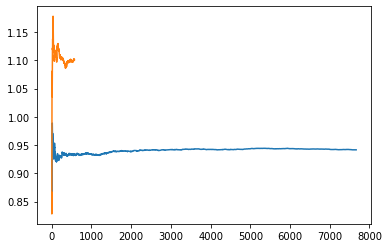

In [ ]:
cnn_trainer.run_training(train_sequence_loader, test_sequence_loader, label_indexer.labels, n_epochs=1)

In [ ]:
torch.cuda.empty_cache()